In [1]:
from collections import defaultdict as ddict
from copy import deepcopy as copy
import pickle
import matplotlib.pyplot as plt
import random
import os

# import tensorflow as tf

# from tensorflow import feature_column,keras
# from tensorflow.keras import layers
# from tensorflow.python.keras.layers import Input, Dense
# from tensorflow.python.keras.models import Model

import pandas as pd
import numpy as np
import seaborn as sns

from IPython.core.display import HTML
from IPython.display import Image, display

#!source activate my-rdkit-env && python 
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Draw.rdMolDraw2D import MolDraw2DSVG
from rdkit.Chem.rdmolops import SanitizeFlags
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,MinMaxScaler
from sklearn.svm import SVR
from sklearn.cluster import KMeans
import sys
#import dill
import joblib
# Set the RDKit logging level to CRITICAL, because 
# lot of RDKit errors occur during the extraction of the 
# fragments. However, the corresponding molecules are 
# corrected in the further course.
RDLogger.logger().setLevel(RDLogger.CRITICAL)

# In many cases NaN
not_used_desc = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge']

# Create a descriptor calculator for all RDKit descriptors except the ones above
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13757146439462213808
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5856362496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14701078111948966240
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2022-06-21 15:41:15.172831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 15:41:15.200176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 15:41:15.203818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 15:41:15.204211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
def show(df):
    return HTML(df.to_html(notebook=True))

In [4]:
#note only characters for the first 20 elements is included
#for organic molecules this should be sufficient

SMILES_CHARS = [
    ' ',
    '#', '%', '(', ')', '+', '-', '.', '/',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    '=', '@',
    'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
    'R', 'S', 'T', 'V', 'X', 'Z',
    '[', '\\', ']',
    'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
    't', 'u'
]

In [5]:
smi_enc_dict = dict( (ch, i) for i, ch in enumerate(SMILES_CHARS) )
smi_dec_dict = dict( (i, ch) for i, ch in enumerate(SMILES_CHARS)  )

In [6]:
def smiles_encoder(smiles, max_length=300):
    smi_mat = np.zeros((max_length, len(SMILES_CHARS)))
    for ID, char in enumerate(smiles):
        smi_mat[ID, smi_enc_dict[char]] = 1
    return smi_mat

def smiles_decoder(smi_mat):
    smi_str = ''
    smi_mat = smi_mat.argmax(axis=-1)
    for i in smi_mat:
        smi_str += smi_dec_dict[i]
    return smi_str


In [7]:
# Preparring datasets by matching the dataset lengths (dataX will be the SMILES strings and dataY will be individual characters in the SMILE string)
# seq_length = 137

In [8]:
sdf_path = os.path.join(os.getcwd(), 'compounds.sdf')

In [9]:
dataset = PandasTools.LoadSDF(sdf_path)

,BROAD_CPD_ID,CPD_NAME,CPD_TYPE,CPD_SMILES,ID,ROMol
0,BRD-K59962020,BRD2020,BIO,Cc1cc2nc(NCCCO)n(CC(=O)c3cc(c(O)c(c3)C(C)(C)C)...,BRD2020,
1,BRD-K15888437,BRD-K15888437,BIO,CCc1cc2c(cc1OC(C)=O)oc(C)c(-c1nc3ccccc3n1C)c2=O,BRD-K15888437,
2,BRD-K19499941,BRD-K19499941,BIO,CCCCCCCN(C(=O)CCl)c1cccc(C)c1,BRD-K19499941,
3,BRD-K03704870,BRD-K03704870,BIO,CCc1ccc(OCC(=O)Nc2nnc[nH]2)cc1,BRD-K03704870,

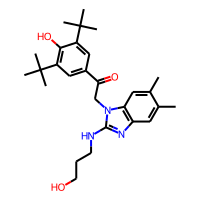
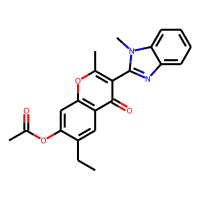
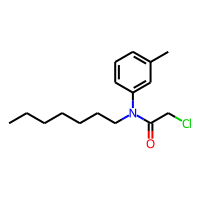
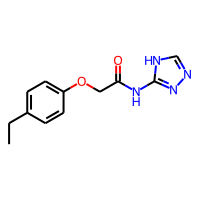

In [10]:
show(dataset.head(4))

In [11]:
smiles_train, smiles_test = train_test_split(dataset["CPD_SMILES"], random_state=20)

print(smiles_train.shape)
print(smiles_test.shape)

(24243,)
(8081,)


In [12]:
charset = set("".join(list(dataset.CPD_SMILES)) + "!E")

char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))

In [13]:
max_length = max([len(smile) for smile in dataset.CPD_SMILES]) + 5

In [14]:
print(str(charset))
print(len(charset), max_length)

{'2', '[', '#', 'O', ']', 'B', '+', 's', 'r', 'P', '6', '.', 'N', 'S', '!', 'E', '\\', 'C', '(', 'n', ')', 'H', 'o', '3', 'e', '4', '@', '-', '1', 'F', 'c', '=', '7', '5', 'l', 'I', '/'}
37 230


In [15]:
def vectorise(smiles, charset, max_length=300):
        one_hot =  np.zeros((smiles.shape[0], max_length , len(charset)))
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [16]:
X_train, Y_train = vectorise(smiles_train.values, charset, max_length=max_length)
X_test, Y_test = vectorise(smiles_test.values, charset, max_length=max_length)


In [17]:
test_smi = X_train[0]

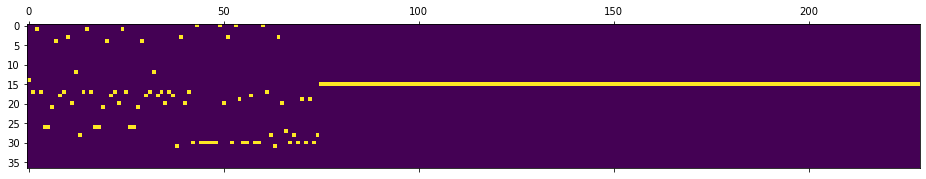

In [18]:
plt.matshow(X_train[0].T)

In [24]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
# lstm_dim = 64

In [25]:
#setup molecular encoder

inputs = Input(shape=input_shape)
mol_encoder = LSTM(64, return_state=True, unroll=False)
outputs, state_h, state_c = mol_encoder(inputs)

#concatenate states into single tensor
states = Concatenate(axis=-1)([state_h, state_c])

c_h_concat = Dense(64, activation='relu')
c_h_ouputs = c_h_concat(states)


In [26]:
#now setup decoder

decode_h = Dense(64, activation='relu')
decode_c = Dense(64, activation='relu')

state_h_decoded = decode_h(c_h_ouputs)
state_c_decoded = decode_c(c_h_ouputs)

encoder_states = [state_h_decoded, state_c_decoded]

decoder_inputs = Input(shape=input_shape)
#decoder
decoder_lstm = LSTM(64,return_sequences=True, unroll=False)

decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#define the model that predicts next character
model = Model([inputs, decoder_inputs], decoder_outputs)

print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 229, 37)]    0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 64),         26112       ['input_3[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128)          0           ['lstm_2[0][1]',                 
                                                                  'lstm_2[0][2]']           

In [27]:
image_model = tf.keras.utils.plot_model(model, "RNN_de_novo_generator.png", show_shapes=True)
display(Image(filename="RNN_de_novo_generator.png"))

NameError: name 'tensorflow' is not defined

In [224]:
from tensorflow.keras.callbacks import History, ReduceLROnPlateau
h = History()
red_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.000001, verbose=1, min_delta=1e-5)

In [225]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [226]:
model.fit([X_train,X_train],Y_train,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, red_LR],
                    validation_data=[[X_test,X_test],Y_test ])

2022-06-21 15:39:47.829370: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 783.58MiB (rounded to 821643776)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-06-21 15:39:47.829470: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-06-21 15:39:47.829503: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 162, Chunks in use: 161. 40.5KiB allocated for chunks. 40.2KiB in use in bin. 15.4KiB client-requested in use in bin.
2022-06-21 15:39:47.829524: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2022-06-21 15:39:47.829545:

KeyboardInterrupt: 

In [189]:
#decoder model
import pickle
pickle.dump(h.history, open('RNN_history.p', 'wb'))

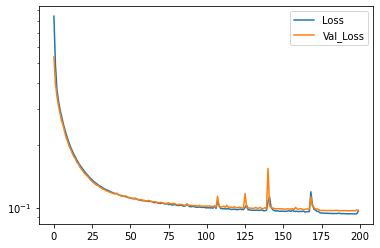

In [190]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [191]:
smiles_to_latent = Model(inputs, c_h_ouputs)
smiles_to_latent.save('smi2lat.h5')

In [192]:
latent_input = Input(shape=(latent_dim, ))

state_h_decoded_2 = decode_h(latent_input)
state_c_decoded_2 = decode_c(latent_input)
latent_to_states = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states.save('lat2state.h5')

In [193]:
print(input_shape[1])

37


In [198]:
# inf_decoder_inputs = Input(batch_shape=(1,1, input_shape[1]))
# inf_decoder_inputs = Input(shape=(1,1), batch_size=input_shape[1])

#correct way using up to date functions
# inf_decoder_inputs = Input(shape=(1,input_shape[1]), batch_size=1)
inf_decoder_inputs = Input(batch_shape=(1,1, input_shape[1]))

inf_decoder_lstm = LSTM(64,return_sequences=True, unroll=False, stateful=True)

inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [199]:
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save('sample_model.h5')

In [200]:
sample_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(1, 1, 37)]              0         
                                                                 
 lstm_17 (LSTM)              (1, 1, 64)                26112     
                                                                 
 dense_19 (Dense)            (1, 1, 37)                2405      
                                                                 
Total params: 28,517
Trainable params: 28,517
Non-trainable params: 0
_________________________________________________________________


In [201]:
x_latent = smiles_to_latent.predict(X_test)

253/253 [==============================] - 1s 3ms/step


In [202]:
from rdkit.Chem import Draw

1/1 [==============================] - 0s 13ms/step
[[3.520825   0.         0.84987926 0.         0.         0.
  0.         1.7861489  3.4875305  0.         0.         0.
  0.         0.         0.         0.         3.1074624  0.
  5.6072845  0.         2.572796   0.         0.         0.
  0.19814068 0.         0.         0.         0.22443607 0.
  0.         3.9394886  1.6131126  3.2570438  0.         2.3150911
  8.427928   0.         0.         0.         1.059811   6.8041353
  0.         0.         0.         2.1956356  0.         0.
  0.         0.         4.624623   0.         0.         0.
  0.         0.         0.         4.510833   1.38754    0.
  0.         0.         0.         0.        ]]
[   0 4473 4470 4468 4464 4459 4457 4456 4454 4451]
28928      CCCc1nc(SCC(=O)N2C(C)Cc3ccccc23)c2c(C)c(C)sc2n1
17888    CN(C)c1ccc2O[C@@H]3[C@@H](C[C@@H](CC(O)=O)O[C@...
11893    CO[C@@H]1CN(C)C(=O)c2cc(NC(=O)c3ccccc3OC)ccc2O...
2082     CC1CCCN(C1)c1nc2n(C)c(=O)n(C)c(=O)c2n1CCSc1nc2..

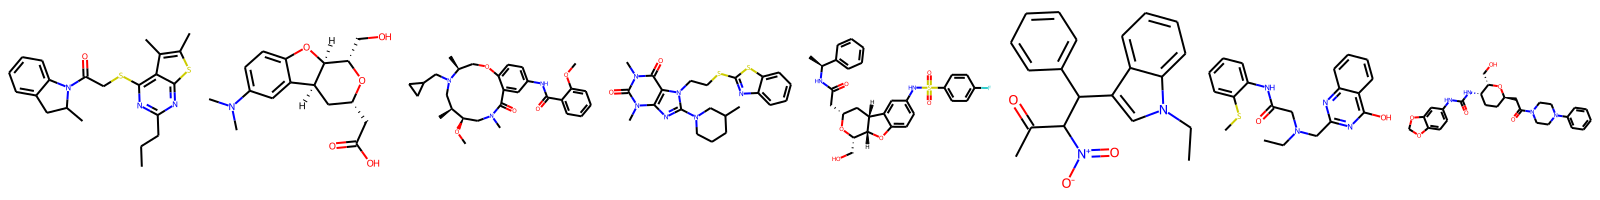

In [203]:
molno = 10
latent_mol = smiles_to_latent.predict(X_test[molno:molno+1])
print(latent_mol)
#we take the absolute difference between latent vectors as the basis for similarity
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))

print(sorti[0:10])

print(smiles_test.iloc[sorti[0:8]])
Draw.MolsToImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))

In [204]:
#Latent space to SMILES
#here we want to sample the latent space
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    
    #NOTE 22 here is the length of the charset! will need to be dynamic!
    samplevec = np.zeros((1,1,37))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(230):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,37))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles


In [206]:
smiles = latent_to_smiles(x_latent[10:11])

1/1 [==============================] - 0s 10ms/step


In [207]:
print(smiles)

COc1ccc(cc1)S(=O)(=O)N[C@@H]1CC[C@@H](CC(=O)NCc2ccc(Cl)c(Cl)c2)O[C@@H]1CO


In [208]:
print(smiles_test.iloc[10:11])

23858    CCOc1ccccc1-c1nnc(S)o1
Name: CPD_SMILES, dtype: object


In [149]:
wrong = 0
for i in range(10):
    smiles = latent_to_smiles(x_latent[i:i+1])
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        print(smiles)
        wrong = wrong + 1
print("%0.1F percent wrongly formatted smiles"%(wrong/float(100)*100))

1/1 [==============================] - 0s 12ms/step
0.0 percent wrongly formatted smiles


In [155]:
i = 10
j= 12
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]


print(latent0)
print(latent1)


# mols1 = []
# ratios = np.linspace(0,1,25)
# for r in ratios:
#     #print r
#     rlatent = (1.0-r)*latent0 + r*latent1
#     smiles  = latent_to_smiles(rlatent)
#     mol = Chem.MolFromSmiles(smiles)
#     if mol:
#         mols1.append(mol)
#     else:
#         print(smiles)
# Draw.MolsToGridImage(mols1, molsPerRow=5)

[[0.        0.        0.        0.        0.        0.        3.3962553
  2.4129176 0.        0.        0.        0.        0.        0.
  3.4229896 0.        0.        0.        0.        4.6143823 0.
  0.        0.        0.        0.        0.        0.        0.
  5.9514337 0.        0.        0.        6.7490697 0.        0.
  0.        5.4053397 0.        0.        0.        0.        0.
  1.8550649 0.        0.        0.        0.        0.        7.859621
  3.766829  2.460815  0.        0.        0.        1.4726045 0.
  0.        0.        0.        0.        5.9216866 0.        1.564821
  0.       ]]
[[0.        0.        0.        0.        0.        0.        3.3962553
  2.4129176 0.        0.        0.        0.        0.        0.
  3.4229896 0.        0.        0.        0.        4.6143823 0.
  0.        0.        0.        0.        0.        0.        0.
  5.9514337 0.        0.        0.        6.7490697 0.        0.
  0.        5.4053397 0.        0.        0.      